In [5]:
%run '/mnt/berger2/equipes/IGE/meom/workdir/berger2/fonctions/meom_fonctions/fonctions.ipynb'

import numpy as np
import matplotlib.pyplot as plt
import scipy.io.netcdf as netcdf
import qgutils as qg
from matplotlib import ticker, cm
plt.ion()

In [6]:
#paramètres gravés dans le marbre pour le stage

Delta = 10000                               #grid spacing
f0 = 9.37456E-05                           #paramètre de Coriolis
dh = np.array([350,750,2900])              #hauteurs des couches océaniques
dh_b = np.array([(dh[0]+dh[1])/2,(dh[0]+dh[1])/2])
g_prime = np.array([2.5E-02,1.25E-02])     #gravités réduites aux interfaces
Beta = 1.75360E-11
delta_ek = 5                               #ocean bottom Ekman thickness 
nu4 = 2E09                                 #bi-harmonic viscosity
Ht = np.sum(dh)
Ht_b = np.sum(dh_b)
toc = np.array([1.31693E+01,1.81693E+01,2.41693E+01])
bf = delta_ek*f0/(2*dh[-1])

#fréquences Brunt-vaisala

N_12 = g_prime[0]/((dh[0]+dh[1])/2)
N_23 = g_prime[1]/((dh[1]+dh[2])/2)
N2 = np.array([N_12,N_23])

In [7]:
dir_abs  = '/mnt/berger2/equipes/IGE/meom/workdir/berger2/qgcm-data/double_gyre_coupled/outdata_7_dt10/'
dir_rel  = '/mnt/berger2/equipes/IGE/meom/workdir/berger2/qgcm-data/double_gyre_coupled/outdata_6tdiff_dt10/'

file0 = 'ocpo.nc'
file1 = 'ocsst.nc'

In [8]:
#get files psi
pfile_abs = dir_abs + file0
pfile_rel = dir_rel + file0

toc_file_abs = dir_abs + file1
toc_file_rel = dir_rel + file1


f_abs = netcdf.netcdf_file(dir_abs + file0,'r')
f_rel = netcdf.netcdf_file(dir_rel + file0,'r')


In [9]:
#size

si_t = f_abs.variables['time'][:].copy().size

p = qg.read_qgcm(pfile_abs, 0, var='p', rescale = 1/f0, interp = True, subtract_bc = False )
nz,ny,nx = p.shape

In [10]:
%%time
# compute means 


p_me_abs = np.zeros((nz,ny,nx))
p_me_abs_avc = np.zeros((nz,ny,nx))

p_me_rel = np.zeros((nz,ny,nx))
p_me_rel_avc = np.zeros((nz,ny,nx))
n_me = 1

for it in range(0,si_t):
  
    p_abs = qg.read_qgcm(pfile_abs, it, var='p', rescale = 1/f0, interp = True, subtract_bc = True)
    p_abs_avc = qg.read_qgcm(pfile_abs, it, var='p', rescale = 1/f0, interp = True, subtract_bc = False)
    
    p_rel = qg.read_qgcm(pfile_rel, it, var='p', rescale = 1/f0, interp = True, subtract_bc = True)
    p_rel_avc = qg.read_qgcm(pfile_rel, it, var='p', rescale = 1/f0, interp = True, subtract_bc = False)
    
    p_me_abs += (p_abs - p_me_abs)/n_me
    p_me_abs_avc += (p_abs_avc - p_me_abs_avc)/n_me
    
    p_me_rel += (p_rel - p_me_rel)/n_me
    p_me_rel_avc += (p_rel_avc - p_me_rel_avc)/n_me
    
    n_me += 1

CPU times: user 1min 1s, sys: 3.91 s, total: 1min 5s
Wall time: 9min 43s


In [11]:
#other mean quantities derived from the mean streamfunction

u_me_abs,v_me_abs = qg.comp_vel(p_me_abs, Delta=Delta, loc='center')
u_me_abs_avc, v_me_abs_avc = qg.comp_vel(p_me_abs_avc, Delta=Delta, loc='center')

u_me_rel,v_me_rel = qg.comp_vel(p_me_rel, Delta=Delta, loc='center')
u_me_rel_avc, v_me_rel_avc = qg.comp_vel(p_me_rel_avc, Delta=Delta, loc='center')

b_me_abs = qg.p2b(p_me_abs, dh, f0)
b_me_abs_avc = qg.p2b(p_me_abs_avc, dh, f0)

b_me_rel = qg.p2b(p_me_rel, dh, f0)
b_me_rel_avc = qg.p2b(p_me_rel_avc, dh, f0)

In [14]:
%%time

#MPE to EPE

mpe2epe_abs_me = np.zeros((nz-1,nx,ny))
mpe2epe_abs_avc_me =np.zeros((nz-1,nx,ny))

mpe2epe_rel_me =np.zeros((nz-1,nx,ny))
mpe2epe_rel_avc_me =np.zeros((nz-1,nx,ny))


n_me=1

for it in range(0,si_t):
    
    p_abs = qg.read_qgcm(pfile_abs, it, var='p', rescale = 1/f0, interp = True, subtract_bc = True)
    p_rel = qg.read_qgcm(pfile_rel, it, var='p', rescale = 1/f0, interp = True, subtract_bc = True)
    p_abs_avc = qg.read_qgcm(pfile_abs, it, var='p', rescale = 1/f0, interp = True, subtract_bc = False)
    p_rel_avc = qg.read_qgcm(pfile_rel, it, var='p', rescale = 1/f0, interp = True, subtract_bc = False) 
    
    u_abs,v_abs = qg.comp_vel(p_abs, Delta=Delta, loc='center')
    u_rel,v_rel = qg.comp_vel(p_rel, Delta=Delta, loc='center')
    u_abs_avc,v_abs_avc = qg.comp_vel(p_abs_avc, Delta=Delta, loc='center')
    u_rel_avc,v_rel_avc = qg.comp_vel(p_rel_avc, Delta=Delta, loc='center')
    
    b_abs = qg.p2b(p_abs, dh, f0)
    b_rel = qg.p2b(p_rel, dh, f0)
    b_abs_avc = qg.p2b(p_abs_avc, dh, f0)
    b_rel_avc = qg.p2b(p_rel_avc, dh, f0)
  
    
    u_p_abs = u_abs - u_me_abs
    v_p_abs = v_abs - v_me_abs
    b_p_abs = b_abs - b_me_abs
    
    u_p_abs_avc = u_abs_avc - u_me_abs_avc
    v_p_abs_avc = v_abs_avc - v_me_abs_avc
    b_p_abs_avc = b_abs_avc - b_me_abs_avc
    
    u_p_rel = u_rel - u_me_rel
    v_p_rel = v_rel - v_me_rel
    b_p_rel = b_rel - b_me_rel
    
    u_p_rel_avc = u_rel_avc - u_me_rel_avc
    v_p_rel_avc = v_rel_avc - v_me_rel_avc
    b_p_rel_avc = b_rel_avc - b_me_rel_avc
        
    u_p_abs_use = reduce_z_dim(u_p_abs, dh)
    v_p_abs_use = reduce_z_dim(v_p_abs, dh)
    u_p_abs_avc_use = reduce_z_dim(u_p_abs_avc, dh)
    v_p_abs_avc_use = reduce_z_dim(v_p_abs_avc, dh)
    u_p_rel_use = reduce_z_dim(u_p_rel, dh)
    v_p_rel_use = reduce_z_dim(v_p_rel, dh)
    u_p_rel_avc_use = reduce_z_dim(u_p_rel_avc, dh)
    v_p_rel_avc_use = reduce_z_dim(v_p_rel_avc, dh)
                                 
    u_b_p_abs = u_p_abs_use*b_p_abs
    v_b_p_abs = v_p_abs_use*b_p_abs
    
    u_b_p_abs_avc = u_p_abs_avc_use*b_p_abs_avc
    v_b_p_abs_avc = v_p_abs_avc_use*b_p_abs_avc
    
    u_b_p_rel = u_p_rel_use*b_p_rel
    v_b_p_rel = v_p_rel_use*b_p_rel
    
    u_b_p_rel_avc = u_p_rel_avc_use*b_p_rel_avc
    v_b_p_rel_avc = v_p_rel_avc_use*b_p_rel_avc
    
    mpe2epe_abs = -(b_me_abs/N2[:,None,None])*(div_x(u_b_p_abs, Delta)+div_y(v_b_p_abs,Delta))
    mpe2epe_abs_avc = -(b_me_abs_avc/N2[:,None,None])*(div_x(u_b_p_abs, Delta)+div_y(v_b_p_abs,Delta))

    mpe2epe_rel = -(b_me_rel/N2[:,None,None])*(div_x(u_b_p_rel, Delta)+div_y(v_b_p_rel,Delta))
    mpe2epe_rel_avc = -(b_me_rel_avc/N2[:,None,None])*(div_x(u_b_p_rel, Delta)+div_y(v_b_p_rel,Delta))
    
    mpe2epe_abs_me += (mpe2epe_abs - mpe2epe_abs_me)/n_me 
    mpe2epe_abs_avc_me += (mpe2epe_abs_avc - mpe2epe_abs_avc_me)/n_me 

    mpe2epe_rel_me += (mpe2epe_rel - mpe2epe_rel_me)/n_me 
    mpe2epe_rel_avc_me += (mpe2epe_rel_avc - mpe2epe_rel_avc_me)/n_me 
    
    
    n_me += 1
    


CPU times: user 2min 31s, sys: 3.99 s, total: 2min 35s
Wall time: 2min 41s


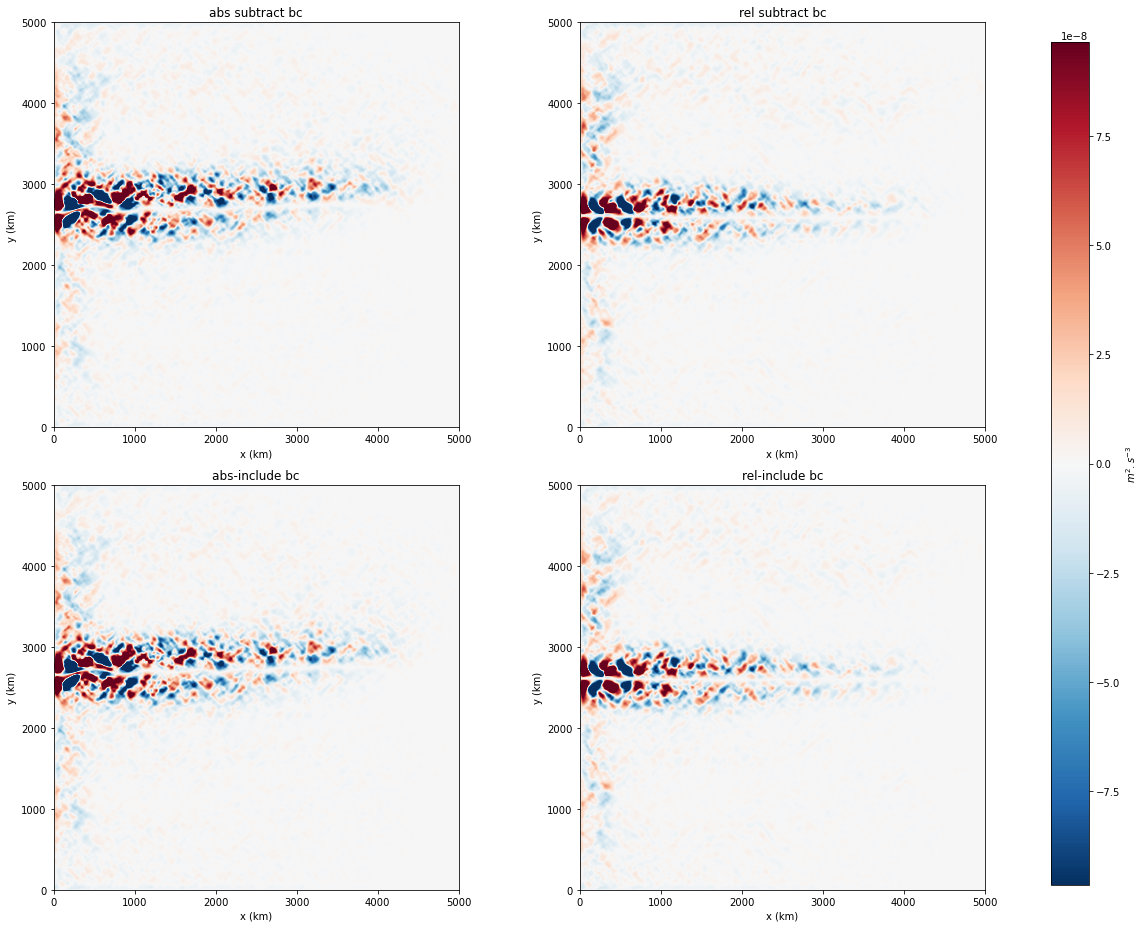

In [44]:
mpe2epe_abs_i = -integral_z(mpe2epe_abs_me, dh, Delta, Ht)
mpe2epe_rel_i = -integral_z(mpe2epe_rel_me, dh, Delta, Ht)
mpe2epe_abs_avc_i = -integral_z(mpe2epe_abs_avc_me, dh, Delta, Ht)
mpe2epe_rel_avc_i = -integral_z(mpe2epe_rel_avc_me, dh, Delta, Ht)


maxi = max(np.max(mpe2epe_abs_i),np.abs(np.min(mpe2epe_abs_i)))


fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize = (15,13),tight_layout=True)


col = ax1.imshow(mpe2epe_abs_i, extent= [0,5000,0,5000], cmap='RdBu_r', vmax = maxi/10, vmin = -maxi/10)
ax1.set_aspect('equal')
ax1.set_title('abs subtract bc')
ax1.set_xlabel('x (km)')
ax1.set_ylabel('y (km)')


col2 = ax2.imshow(mpe2epe_rel_i, extent= [0,5000,0,5000], cmap='RdBu_r', vmax = maxi/10, vmin = -maxi/10)
ax2.set_aspect('equal')
ax2.set_title('rel subtract bc')
ax2.set_xlabel('x (km)')
ax2.set_ylabel('y (km)')

col3 = ax3.imshow(mpe2epe_abs_avc_i, extent= [0,5000,0,5000], cmap='RdBu_r', vmax = maxi/10, vmin = -maxi/10)
ax3.set_aspect('equal')
ax3.set_title('abs-include bc')
ax3.set_xlabel('x (km)')
ax3.set_ylabel('y (km)')

col4 = ax4.imshow(mpe2epe_rel_avc_i, extent= [0,5000,0,5000], cmap='RdBu_r', vmax = maxi/10, vmin = -maxi/10)
ax4.set_aspect('equal')
ax4.set_title('rel-include bc')
ax4.set_xlabel('x (km)')
ax4.set_ylabel('y (km)')

cax = plt.axes([1, 0.05, 0.035, 0.9])

m2 = plt.cm.ScalarMappable(cmap='RdBu_r')
m2.set_array(mpe2epe_abs_i)
m2.set_clim(-maxi/10, maxi/10)
plt.colorbar(m2,cax).set_label(r'$m^2.s^{-3}$')

In [27]:
tran = 365*86400/(0.01**2)

In [28]:
print('Value for abs cycle should be: 71')
print('')
print('abs, bc substracted:',qg.integral(mpe2epe_abs_me,dh,Delta,average=True)*tran)
print('abs, bc included   :',qg.integral(mpe2epe_abs_avc_me,dh,Delta,average=True)*tran)
print('')
print('Value for rel cycle should be: 85')
print('')
print('rel, bc substracted:',qg.integral(mpe2epe_rel_me,dh,Delta,average=True)*tran)
print('rel, bc included   :',qg.integral(mpe2epe_rel_avc_me,dh,Delta,average=True)*tran)

Value for abs cycle should be: 71

abs, bc substracted: 62.42551959723345
abs, bc included   : 62.42551966718938

Value for rel cycle should be: 85

rel, bc substracted: 12.414675110402442
rel, bc included   : 12.414675084258956
